# Mass Balance Tuning 

In [461]:
import numpy as np 
import xarray as xr
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt 

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


# Load Erik's reference mass balance runs for the 25 parameter
# combinations which statisfy his tuning criteria
MB_ref =  xr.open_dataset("Young_etal_2020_ref_MB.nc")

In [735]:
def poly_fit(ds, deg=1, ret_p=True): 
    # Deal with nan's internally 
    x = ds.Elevation.values
    y = ds.MB.values
    
    # find indexes of nans and sort indexes
    mask = np.where(~np.isnan(x))
    idxs = np.argsort(x[mask])
    
    # Remove the nans and sort the data
    x_ = x[  mask][idxs]
    y_ = y[mask  ][idxs]
    
    fit = np.polyval(np.polyfit(x_, y_, deg), x_)
    
    if ret_p:
        return x_, fit, p
    else:
        return x_, fit
    
def spline_fit(ds, deg=3, ret_p=True):
    # Deal with nan's internally 
    x = ds.Elevation.values
    y = ds.MB.values
    
    # find indexes of nans and sort indexes
    mask = np.where(~np.isnan(x))
    idxs = np.argsort(x[mask])
    
    # Remove the nans and sort the data
    x_sub = x[~np.isnan(x)][::10]
    y_sub = y[~np.isnan(x)][::10]
    
    m = len(x_sub)
    
    idxs = np.argsort(x_sub, kind='heapsort')
    
    x_ = x_sub[idxs]
    y_ = y_sub[idxs]
    

    tck = interpolate.splrep(x_, y_, k=deg, s=240)
    
    fit = interpolate.splev(np.sort(x[~np.isnan(x)]), tck)
    
    if ret_p:
        return np.sort(x[~np.isnan(x)]), fit, tck
    else:
        return np.sort(x[~np.isnan(x)]), fit


In [736]:
x2, y2, p   = poly_fit( MB_ref.mean('ref_run').stack(z=('x', 'y')), deg=2, ret_p=True)
x3, y3, tck = spline_fit(MB_ref.mean('ref_run').stack(z=('x', 'y')), deg=3, ret_p=True)

In [737]:
z = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
b = MB_ref.mean('ref_run').stack(z=('x', 'y')).MB.values
z_ELA = np.nanmean(z_[np.argpartition(np.abs(b_),25)[:25]])

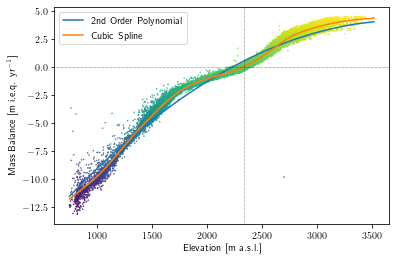

In [738]:
fig, ax = plt.subplots(1,1)

ax.scatter(  MB_ref.Elevation, 
             MB_ref.MB.mean('ref_run'),
           c=MB_ref.MB.mean('ref_run'),
           s=0.25)


ax.plot(x2, y2, label='2nd Order Polynomial')
ax.plot(x3, y3, label='Cubic Spline')
ax.legend()

ax.axhline(0, ls=':', c='k', lw=0.5)
ax.axvline(z_ELA, ls=':', c='k', lw=0.5)

ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('Mb_fits.png', dpi=400, bbox_inches='tight',
            facecolor='white')

In [739]:
def latex_float(f):
    """https://stackoverflow.com/a/13490601/10221482"""
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def piecewise_linear(x, x0, y0, k1, k2):
    """https://stackoverflow.com/a/29384899/10221482"""
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def piecewise_fit(ds, deg=1, ret_p=True): 
    # Deal with nan's internally 
    x = ds.Elevation.values
    y = ds.Accumulation.values
    
    # find indexes of nans and sort indexes
    mask = np.where(~np.isnan(x))
    idxs = np.argsort(x[mask])
    
    # Remove the nans and sort the data
    x_ = x[  mask][idxs]
    y_ = y[mask  ][idxs]
    
    # Fit the model, optimize the slopes and y-intercepts 
    # (and therefore the knot point)
    p , e = optimize.curve_fit(piecewise_linear, x_, y_, p0=[ 2300,0,0,0])
    
    if ret_p:
        return x_, piecewise_linear(x_, *p), p
    else:
        return x_, piecewise_linear(x_, *p)


In [412]:
z_vec, A_vec, p = piecewise_fit( MB_ref.mean('ref_run').stack(z=('x', 'y')))

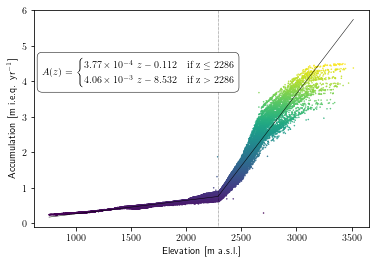

In [413]:
fig, ax = plt.subplots(1,1)

ax.scatter(MB_ref.Elevation, 
             MB_ref.Accumulation.mean('ref_run'),
           c=MB_ref.Accumulation.mean('ref_run'),
           s=0.25)

ax.plot(z_vec, A_vec, c='k', lw=0.5)

ax.axvline(p[0], ls=':', c='k', lw=0.5)


# piecewise linear equation
eq  = ("$A(z) = \\begin{{cases}}"
       " {0} \\; z {1:3.3f} & \\rm{{if }} \\; z \\leq {2:4.0f} \\\ "
       " {3} \\; z {4:3.3f} & \\rm{{if }} \\; z > {5:4.0f} \\\ "
       "\\end{{cases}}$".format(latex_float(p[2]),p[1]-p[2]*p[0],p[0],
                                latex_float(p[3]),p[1]-p[3]*p[0],p[0])
      )

ax.text(0.025, 0.7, eq, transform=ax.transAxes,
       bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.5,
                 linewidth=0.5))

ax.set_ylabel('Accumulation [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('Accum.png', dpi=400, bbox_inches='tight',
            facecolor='white')

## Mass Balance Formulation: 

[Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) model the snow accumulation $A_{\rm snow}$ as function of elevation such that: 
\begin{equation}
     A_{\rm snow}(z) = \sum^{365}_{d=1} 
    \begin{cases}
    \frac{A_{\rm ref}}{365} ( 1 +  (z-z_{\rm ref}) \frac{d A}{ d z})  & \text{if } T(d,z) < T_{\rm snow} ,\\
    0 & \text{if } T(d,z) \geq T_{\rm snow} ,
    \end{cases}
\end{equation}

where $A_{\rm ref}$ (m w.e. a$^{-1}$) is the mean annual precipitation at reference elevation $z_{\rm ref}$ (m a.s.l.), $\frac{d A}{ d z}$ (m$^{-1}$) is the altitudnal precipitation factor, and $T_{\rm snow}$ (K) is the temperature threshold to differeniate between snow and rain. 

__Note__: Units listed follow [Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) and not necessarily what we will end up using in our implementation. Also, $\frac{d A}{ d z}$ is refered to as the altitudnal precipitation factor and has units (m$^{-1}$), whereas we might commonly think of this
parameter as the mass balance gradient which would have units (m w.e. a$^{-1}$ m$^{-1}$). Despite the different units, the magnitude of the scalar quantity appears to be the same. 


Since we seek to model our selection of glaciers, we need to alter the [Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) formulation slightly.

In [434]:
piecewise_linear(np.array([0,1000, 3500],dtype=np.float), *p)

array([-0.11192152,  0.26483472,  5.6763039 ])

In [433]:
-0.112 + (1000)*3.77e-4

0.265

In [406]:
(-8.532/183)

-0.04662295081967213